In [707]:
import pandas as pd
import seaborn as sns
import json
from pandas.io.json import json_normalize
from datetime import date
from datetime import datetime 
from dateutil import relativedelta
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import calendar
from statsmodels.discrete.discrete_model import Probit
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE

## Exploratory Analysis

### The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.



In [143]:
file=open('/Users/ajeustis/Downloads/ultimate_challenge/logins.json', 'r')
file_content=file.read()
file.close()
data=json.loads(file_content)
logins =pd.DataFrame(data)

In [500]:
file2=open('/Users/ajeustis/Downloads/ultimate_challenge/ultimate_data_challenge.json', 'r')
file_content2=file2.read()
file2.close()
data2=json.loads(file_content2)
city=pd.DataFrame(data2)
city.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [145]:
# Look at dataframe
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [146]:
# Sort to get an idea of range
# 4 months of data
logins.sort_values(by = 'login_time')

,login_time
6,1970-01-01 20:12:16
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
3,1970-01-01 20:16:36
2,1970-01-01 20:16:37
...,...
93136,1970-04-13 18:48:52
93137,1970-04-13 18:50:19
93139,1970-04-13 18:54:02
93141,1970-04-13 18:54:23


In [147]:
# Check for NAs
logins.isnull().sum()

login_time    0
dtype: int64

In [148]:
# Get value counts for the log in times and re structure as a dataframe
vc = logins['login_time'].value_counts()
vc = vc.to_frame()
vc = vc.reset_index()
vc.columns = ['login_time', 'counts']
vc.head()

,login_time,counts
0,1970-03-14 17:45:52,3
1,1970-01-09 01:31:25,3
2,1970-04-12 04:03:15,3
3,1970-02-24 23:09:57,3
4,1970-04-04 01:17:40,3


In [149]:
# Get some descriptive info for new dataframe
vc['counts'].describe()

count    92265.000000
mean         1.009505
std          0.098031
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: counts, dtype: float64

In [150]:
# Convert to datetime object
vc['login_time']= pd.to_datetime(vc['login_time']) 
vc.dtypes

login_time    datetime64[ns]
counts                 int64
dtype: object

In [151]:
# Get month and convert to name from integer
vc['month'] = vc['login_time'].dt.month
vc['month'] = vc['month'].apply(lambda x: calendar.month_abbr[x])

In [152]:
vc.head()

,login_time,counts,month
0,1970-03-14 17:45:52,3,Mar
1,1970-01-09 01:31:25,3,Jan
2,1970-04-12 04:03:15,3,Apr
3,1970-02-24 23:09:57,3,Feb
4,1970-04-04 01:17:40,3,Apr


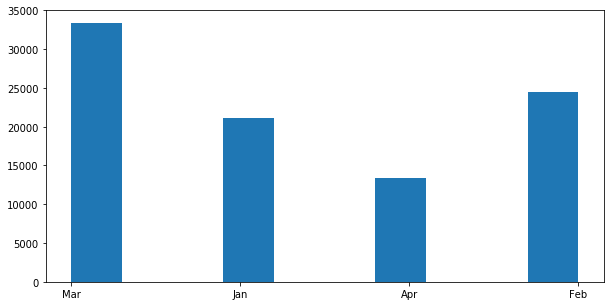

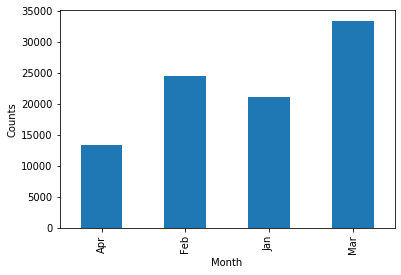

In [128]:
days_values=vc.groupby(['month'])['month'].count().plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Counts')
plt.show()

In [169]:
df = vc.set_index('login_time')
df.head(10)

,counts,month
login_time,,
1970-03-14 17:45:52,3,Mar
1970-01-09 01:31:25,3,Jan
1970-04-12 04:03:15,3,Apr
1970-02-24 23:09:57,3,Feb
1970-04-04 01:17:40,3,Apr
1970-02-12 11:16:53,3,Feb
1970-03-17 01:01:39,3,Mar
1970-01-06 21:45:52,3,Jan
1970-03-29 03:24:57,3,Mar


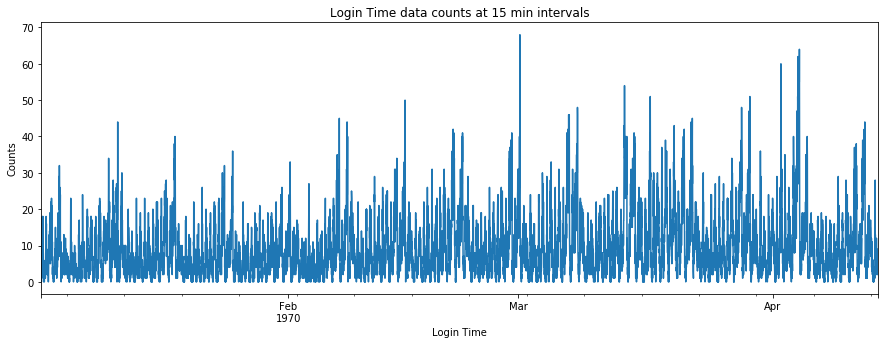

In [188]:
plt.figure(figsize=(15,5))
vc.set_index('login_time').sort_index().resample('15T').size().plot()
plt.title('Login Time data counts at 15 min intervals')
plt.xlabel('Login Time')
plt.ylabel('Counts')
plt.show()

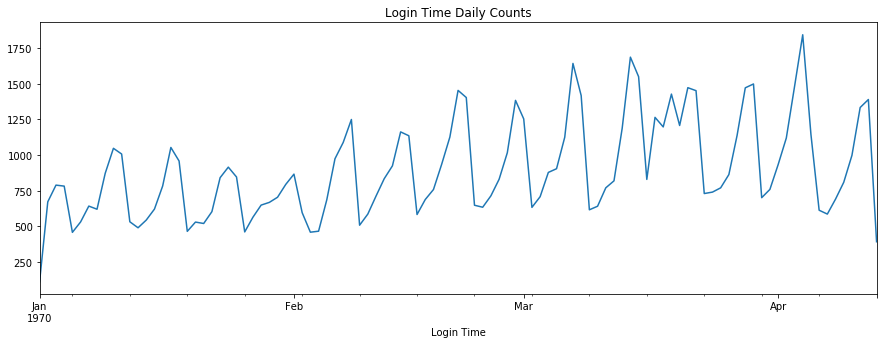

In [189]:
# Daily 
plt.figure(figsize=(15,5))
vc.set_index('login_time').sort_index().resample('1D').size().plot()
plt.title('Login Time Daily Counts')
plt.xlabel('Login Time')
plt.show()

In [ ]:
"""
These plots indicate that logins increase and peak on the weekends. 

Login counts did seem to increase from Jan to April.
"""

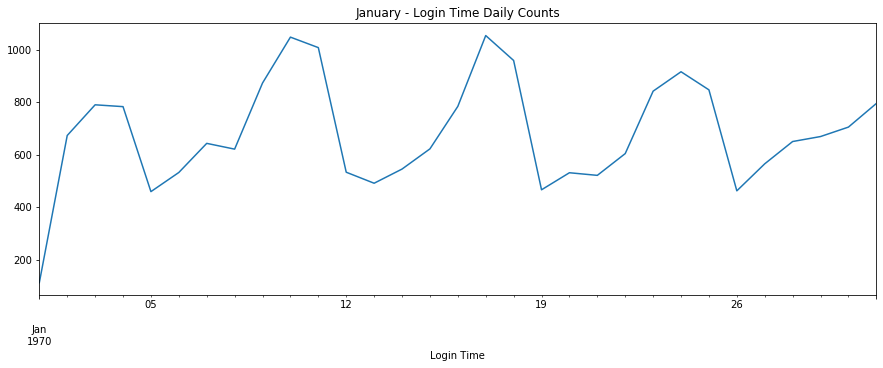

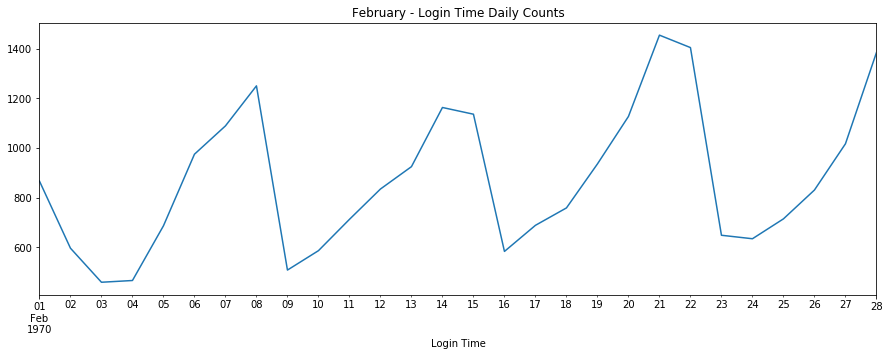

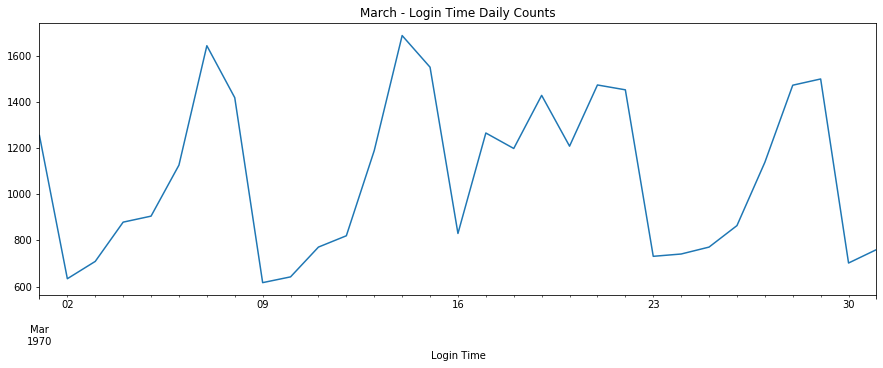

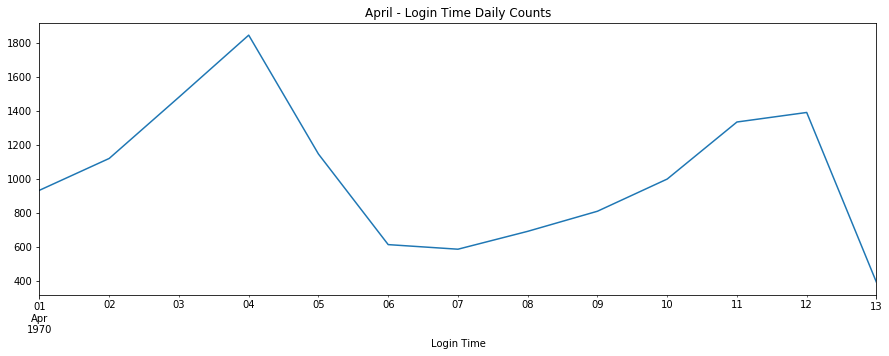

In [211]:
# Daily (subset to each month for a closer look at monthly trends)
plt.figure(figsize=(15,5))
jan = vc[vc['month']=='Jan']
jan.set_index('login_time').sort_index().resample('1D').size().plot()
plt.title('January - Login Time Daily Counts')
plt.xlabel('Login Time')
plt.show()

plt.figure(figsize=(15,5))
feb = vc[vc['month']=='Feb']
feb.set_index('login_time').sort_index().resample('1D').size().plot()
plt.title('February - Login Time Daily Counts')
plt.xlabel('Login Time')
plt.show()

plt.figure(figsize=(15,5))
mar = vc[vc['month']=='Mar']
mar.set_index('login_time').sort_index().resample('1D').size().plot()
plt.title('March - Login Time Daily Counts')
plt.xlabel('Login Time')
plt.show()

plt.figure(figsize=(15,5))
apr = vc[vc['month']=='Apr']
apr.set_index('login_time').sort_index().resample('1D').size().plot()
plt.title('April - Login Time Daily Counts')
plt.xlabel('Login Time')
plt.show()

In [ ]:
"""
These plots indicate that logins peak on the weekends.
"""

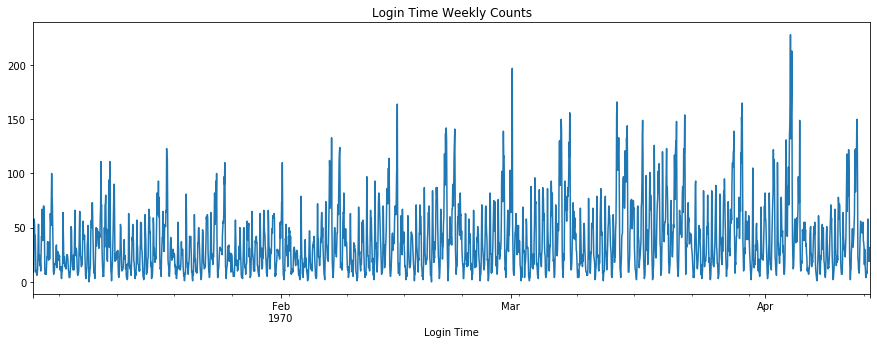

In [202]:
# Weekly 
plt.figure(figsize=(15,5))
vc.set_index('login_time').sort_index().resample('1H').size().plot()
plt.title('Login Time Weekly Counts')
plt.xlabel('Login Time')
plt.show()

## Experimental Design

### The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs. 

### 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
### 2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on: 
### a. how you will implement the experiment. 
### b. what statistical test(s) you will conduct to verify the significance of the observation.
### c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

## Experiment 

### There are several ways one could measure success in this experiment. One is measuring activity of drivers. If driver activity after the implementation of the toll-reimbursement program indicates that drivers are crossing this bridge more and thus serving individuals in both cities more so than before then we have a clear indication that the program is working and drivers no longer feel limited by the toll. Another measure, which really drills down to the bottom line, is profit. Ideally the toll reimbursement program will allow drivers to go to where demand is highest and not feel limited because of a toll, this should result in higher profits for drivers (and thus Ultimate). 

### If the goal of the experiment is to encourage driver partners to be available in both cities then the best measure of success is an increase in the number of toll reimbursements. This means that we need to have a baseline estimate of how many drivers are crossing the bridge to begin with, which could be measured by activity (assessing routes drivers take and counting the number of times they are crossing the bridge and thus paying a toll) or drivers self reporting the number of times they have paid a toll and thus crossed the bridge. 

### Ultimately, we want to look for change in driver behavior. If after the toll reimbursement program, driver behavior has not changed in a meaningful and significant manner then we may want to re-evaluate the toll reimbursement program. 

### I would implement the experiment by determining a baseline estimate of the current amount Ultimate would theoretically need to reimburse drivers for tolls (lets base it on the current log-in data, so the expected reimbursement cost / month based on 4 months of data). Next, I would initiate a trial toll-reimbursement program and track toll reimbursement costs for the same duration of time, maybe a bit longer as we can expect a delay in driver implementation of the program.

### Caveat: Seasonality will likely play a role. Using data to form the baseline estimate may mean taking data from previous years, which has the problem of potentially not being representative of the current usage and trends in Ultimate. Thus our baseline estimate for tolls would likely need to be normalized in such a way that we have seasonally adjusted the means. I think using an ARIMA could be a really useful way to further explort the time-series aspects of this data.

### Once the experiment ended I would perform a z-test to see if the means were different. 

### If the toll reimbursement was significantly larger than the baseline, then we can conclude that the experiment showed that the toll-reimbursement program worked, and drivers did not feel limited or as limited by the toll. 


### Now, whether or not this resulted in increased profit for drivers and Ultimate itself would be a crucial next step to determine if the program was worth it. The bottom line of any company is to ensure they are at least maintaining if not increasing profitability. So a useful follow up analysis would be to determine the profit implications of this program and project future increases or decreases in profit margins as a result.

## Predictive Modeling

### Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
### 1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
### 2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
### 3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).


### Exploratory Analysis + Visualizations

In [501]:
city.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [502]:
city.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [503]:
# Check how many missing values there are and drop them.
city.isnull().sum()
city_clean = city.dropna()

In [507]:
# Create is_retained variable
# If there are no trips in the preceding 30 days then the user is not retained (0), if there were any trips in the 
# previous thirty days then the user is retained (1).
city_clean.loc[city_clean['trips_in_first_30_days'] > 0, 'is_retained'] = 1
city_clean.loc[city_clean['trips_in_first_30_days'] == 0, 'is_retained'] = 0

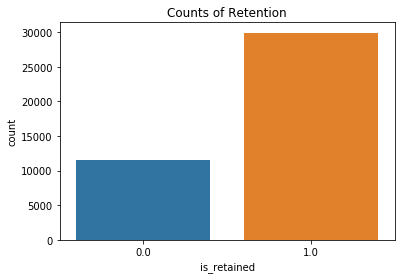

In [508]:
sns.countplot(x='is_retained',data=city_clean)
plt.title("Counts of Retention")
plt.show()

In [509]:
retained = len(city_clean[city_clean['is_retained'] == 1.0])
not_retained = len(city_clean[city_clean['is_retained'] == 0.0])
total = len(city_clean)
fraction_retained = round((retained / total) * 100,2)

print(str(retained) + " passengers have had a trip in the last 30 days")
print(str(not_retained) + " passengers have no had a trip in the last 30 days")
print(str(fraction_retained) + "%" + " of passengers are retained")

29921 passengers have had a trip in the last 30 days
11524 passengers have no had a trip in the last 30 days
72.19% of passengers are retained


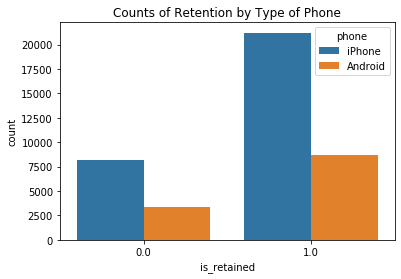

In [510]:
sns.countplot(x='is_retained',hue='phone',data=city_clean)
plt.title("Counts of Retention by Type of Phone")
plt.show()

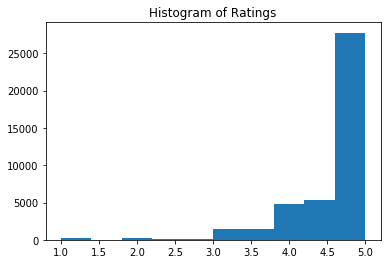

In [511]:
plt.hist(city_clean['avg_rating_of_driver'])
plt.title('Histogram of Ratings')
plt.show()

In [512]:
city_clean.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
is_retained               float64
dtype: object

In [513]:
# Convert dates to datetime objects
city_clean.loc[:,('signup_date')] = pd.to_datetime(city_clean['signup_date']) 
city_clean.loc[:,('last_trip_date')]= pd.to_datetime(city_clean['last_trip_date']) 

In [514]:
city_clean.loc[:,('months_active')] = city_clean['last_trip_date'] - city_clean['signup_date']
city_clean.dtypes

city                               object
trips_in_first_30_days              int64
signup_date                datetime64[ns]
avg_rating_of_driver              float64
avg_surge                         float64
last_trip_date             datetime64[ns]
phone                              object
surge_pct                         float64
ultimate_black_user                  bool
weekday_pct                       float64
avg_dist                          float64
avg_rating_by_driver              float64
is_retained                       float64
months_active             timedelta64[ns]
dtype: object

In [515]:
# Create variable for number of active months
# Determined as last_trip_date - signup_date
city_clean.loc[:,('months_active')] = city_clean['last_trip_date'].dt.month - city_clean['signup_date'].dt.month
city_clean.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,is_retained,months_active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1.0,5
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0.0,4
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,1.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1.0,5
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,1.0,2


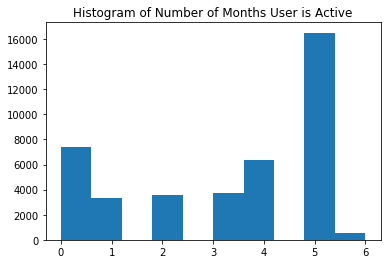

In [516]:
plt.hist(city_clean['months_active'])
plt.title('Histogram of Number of Months User is Active')
plt.show()

In [517]:
city_clean['months_active'].value_counts()

5    16506
0     7371
4     6376
3     3762
2     3562
1     3339
6      529
Name: months_active, dtype: int64

In [518]:
"""
We want to predict whether or not a user will be active in the 6th month. The best way to do this is to create
a variable with two binary outcomes and then try to predict it: "6months_active" = 0 or 1. 1 is yes, 0 is no.
"""

'\nWe want to predict whether or not a user will be active in the 6th month. The best way to do this is to create\na variable with two binary outcomes and then try to predict it: "6months_active" = 0 or 1\n'

In [519]:
# Create binary variable for 6months_active
city_clean.loc[city_clean['months_active'] > 5, '6months_active'] = 1
city_clean.loc[city_clean['months_active'] <= 5, '6months_active'] = 0

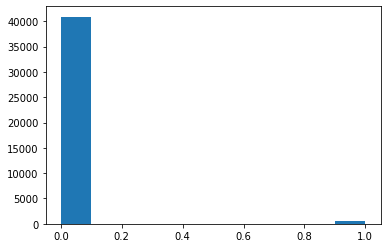

In [520]:
plt.hist(city_clean['6months_active'])
plt.show()

In [521]:
# Get dummy variables for categorical variables
predictors = pd.get_dummies(city_clean,columns= ['city','phone', 'ultimate_black_user'], drop_first = True)
predictors = predictors.drop(columns = ['signup_date', 'last_trip_date'])

In [686]:
# Create model
Y = city_clean['6months_active']
X = predictors.drop(columns = ['6months_active', 'months_active'])
X

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,is_retained,city_King's Landing,city_Winterfell,phone_iPhone,ultimate_black_user_True
0,4,4.7,1.10,15.4,46.2,3.67,5.0,1.0,1,0,1,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,0.0,0,0,0,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,1.0,0,0,1,0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,1.0,1,0,1,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,1.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
49993,3,4.8,1.11,11.1,55.6,2.53,4.7,1.0,0,0,1,1
49994,1,4.6,1.44,37.5,25.0,2.25,4.5,1.0,0,0,1,0
49995,0,5.0,1.00,0.0,100.0,5.63,4.2,0.0,1,0,1,0
49997,0,5.0,1.00,0.0,100.0,3.86,5.0,0.0,0,1,0,1


In [687]:
# Scale data
standardized_X = preprocessing.scale(X)

In [688]:
# Over-sampling for our imbalanced dataset
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(standardized_X, Y, test_size=0.30, random_state=0)
columns = X.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['6months_active'])

# Check the numbers 
print("length of oversampled data is ",len(os_data_X))
print("Number of users with no activity at 6 months",len(os_data_y[os_data_y['6months_active']==0]))
print("Number of users with activity at 6 months",len(os_data_y[os_data_y['6months_active']==1]))
print("Proportion of users with no activity at 6 months ",len(os_data_y[os_data_y['6months_active']==0])/len(os_data_X))
print("Proportion of users with activity at 6 months ",len(os_data_y[os_data_y['6months_active']==1])/len(os_data_X))

length of oversampled data is  57264
Number of users with no activity at 6 months 28632
Number of users with activity at 6 months 28632
Proportion of users with no activity at 6 months  0.5
Proportion of users with activity at 6 months  0.5


#### Implement Recursive Feature Elimination. This is a model construction method where we repeatedly construct a model and choose the best or worst performing feature, removing this feature and repeating the process with the remaining features. This process is applied until all features have been used. The goal is feature selection by considering smaller and smaller sets of features.

In [689]:
logreg = LogisticRegression()
rfe = RFE(logreg,20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1]


In [690]:
# Implement the model
logit_model = sm.Logit(os_data_y,os_data_X)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.612239
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         6months_active   No. Observations:                57264
Model:                          Logit   Df Residuals:                    57252
Method:                           MLE   Df Model:                           11
Date:                Tue, 02 Jun 2020   Pseudo R-squ.:                  0.1167
Time:                        11:45:04   Log-Likelihood:                -35059.
converged:                       True   LL-Null:                       -39692.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
trips_in_first_30_days       0.3508      0.011     32.461      0.000       0.330

In [691]:
# Remove variables that are not significant in the model 
X = os_data_X.drop(columns = ['avg_rating_by_driver'])

In [692]:
# Change y to 1D array
Y = os_data_y['6months_active']

In [693]:
# Re run the model
logit_model = sm.Logit(Y, X)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.612251
         Iterations 6
                             Results: Logit
Model:                  Logit              Pseudo R-squared:   0.117     
Dependent Variable:     6months_active     AIC:                70141.8922
Date:                   2020-06-02 11:45   BIC:                70240.4019
No. Observations:       57264              Log-Likelihood:     -35060.   
Df Model:               10                 LL-Null:            -39692.   
Df Residuals:           57253              LLR p-value:        0.0000    
Converged:              1.0000             Scale:              1.0000    
No. Iterations:         6.0000                                           
-------------------------------------------------------------------------
                          Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------
trips_in_first_30_days    0.3514   0.010

In [694]:
# Split data up into test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [695]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test,y_test)))

Accuracy of logistic regression classifier on test set: 0.67


In [698]:
# Confusion Matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[5667 2905]
 [2687 5921]]


In [699]:
# Precision, recall, F-measure and support
# Classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.68      0.66      0.67      8572
         1.0       0.67      0.69      0.68      8608

    accuracy                           0.67     17180
   macro avg       0.67      0.67      0.67     17180
weighted avg       0.67      0.67      0.67     17180



In [ ]:
# Of the entire test set 67% of users showed activity at 6 months. 

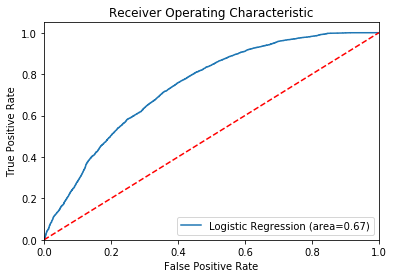

In [700]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr,tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label = 'Logistic Regression (area=%0.2f)' % logit_roc_auc)
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = "lower right")
plt.show()

In [701]:
# Look at model scores
print(logmodel.score(X_train, y_train))
print(logmodel.score(X_test, y_test))

0.5747430396168047
0.5728172293364377


### It seems as though Ultimate is already doing fairly well at retaining users. But lets look at feature importance to see if there are features that Ultimate should focus on more. 

In [720]:
# Extract feature importance from logistic regression coefficients
importance = logreg.coef_[0]
importance

coeff_df = pd.DataFrame(importance, X.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
trips_in_first_30_days,0.385981
avg_rating_of_driver,0.112601
avg_surge,-0.223718
surge_pct,0.226201
weekday_pct,0.504009
avg_dist,-0.619713
is_retained,-0.043725
city_King's Landing,0.421859
city_Winterfell,0.323231
phone_iPhone,0.368816


Feature: 0, Score: 0.38598
Feature: 1, Score: 0.11260
Feature: 2, Score: -0.22372
Feature: 3, Score: 0.22620
Feature: 4, Score: 0.50401
Feature: 5, Score: -0.61971
Feature: 6, Score: -0.04372
Feature: 7, Score: 0.42186
Feature: 8, Score: 0.32323
Feature: 9, Score: 0.36882
Feature: 10, Score: 0.18837


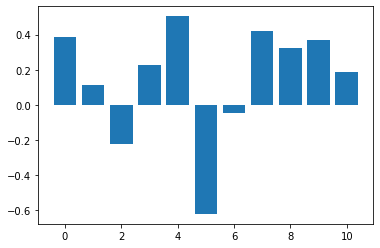

In [716]:
for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
        
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.xlabel('')
pyplot.show()

### This shows the impact the coefficients have on the predicted variable. 

In [ ]:
# Feature importance using random forest

In [728]:
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(X, Y)

for name, importance in zip(X.columns, rnd_clf.feature_importances_):
     print(name, "=", importance)

trips_in_first_30_days = 0.10872904576563473
avg_rating_of_driver = 0.15006894652552388
avg_surge = 0.1515627048425405
surge_pct = 0.1525534579876747
weekday_pct = 0.2275780630562483
avg_dist = 0.10410387993322145
is_retained = 0.012027520342022473
city_King's Landing = 0.02085097181225668
city_Winterfell = 0.019131869535796715
phone_iPhone = 0.030098506699433123
ultimate_black_user_True = 0.023295033499647386


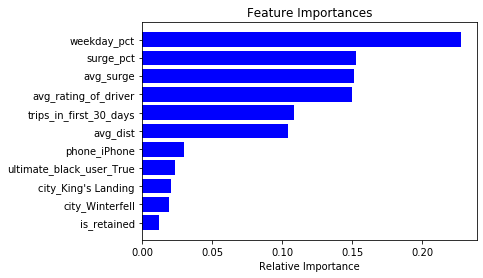

In [729]:
features = X.columns
importances = rnd_clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### The feature importance plot from the random forest shows that weekday_pct is the most important variable, followed by a tie between surge_pct, avg_surge and avg_rating_of_driver. It appears that these variables are better predictors for whether a driver will continue to use Ultimate. 